In [11]:
# Make BAMS time-series plot of Ft. Myers data from Ap
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string


In [2]:
# make a list of all of the time-series
data_dir = "C:/crs/proj/2025_NOPP_comparison/Ian_figure/"
flist = glob.glob(data_dir+'*.csv')
print(len(flist))
print(flist)

24
['C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8723970.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8724580.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8725110.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8725520.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726384.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726520.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726607.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726674.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726724.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8727520.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8728690.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729108.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729210.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729840.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8732828.csv', 'C:/crs/proj/2025_NOPP_comparison/Ian_figure\\8735180.csv', 'C:/crs/proj/2025_NOPP_comparison/Ia

In [18]:
# Ft Meyers is 8725520
fn = '8725520.csv'
df = pd.read_csv(data_dir+fn)
print(df)

                    time     obs    pred       mod
0    2022-09-27 00:00:00  0.4625  0.1645  0.343610
1    2022-09-27 00:10:00  0.4505  0.1515  0.333432
2    2022-09-27 00:20:00  0.4440  0.1420  0.323165
3    2022-09-27 00:30:00  0.4320  0.1330  0.313652
4    2022-09-27 00:40:00  0.4205  0.1210  0.303522
..                   ...     ...     ...       ...
428  2022-09-29 23:20:00  0.4580  0.1570  0.808853
429  2022-09-29 23:30:00  0.4520  0.1585  0.804642
430  2022-09-29 23:40:00  0.4475  0.1590  0.800205
431  2022-09-29 23:50:00  0.4410  0.1590  0.795485
432  2022-09-30 00:00:00  0.4400  0.1580  0.790627

[433 rows x 4 columns]


In [25]:
print(df.dtypes)
df["time"] = pd.to_datetime(df["time"])
print(df.dtypes) 

time     object
obs     float64
pred    float64
mod     float64
dtype: object
time    datetime64[ns]
obs            float64
pred           float64
mod            float64
dtype: object


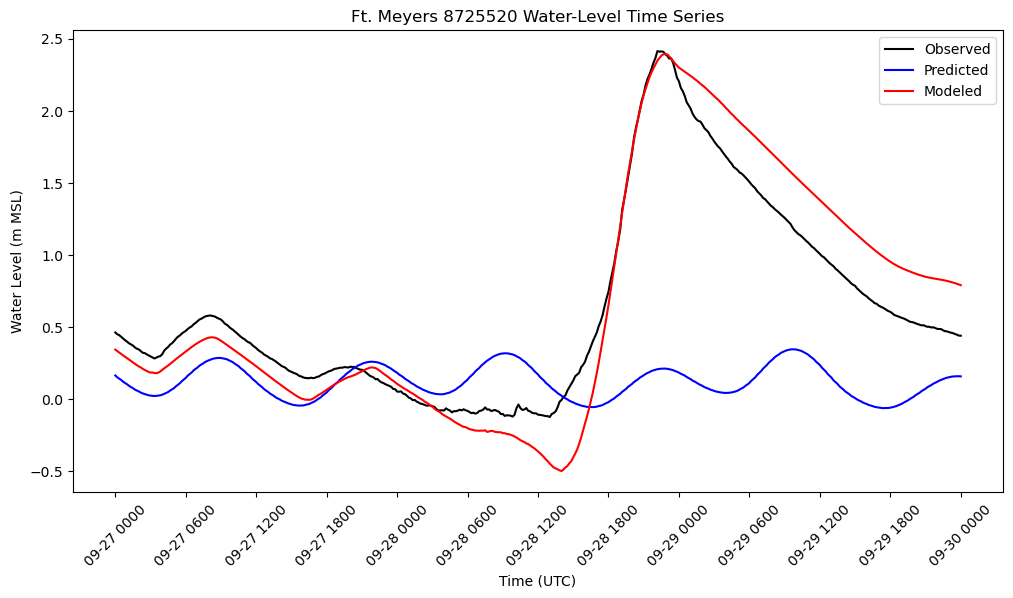

In [30]:
# Plot all three time series
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["obs"], label="Observed", color="k")
plt.plot(df["time"], df["pred"], label="Predicted", color="b")
plt.plot(df["time"], df["mod"], label="Modeled", color="r")

# Set time axis to label every 6 hours
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H%M"))

# Improve readability
plt.xticks(rotation=45)
plt.xlabel("Time (UTC)")
plt.ylabel("Water Level (m MSL)")
plt.title("Ft. Meyers 8725520 Water-Level Time Series")
plt.legend()